# <center>CommunityDetectionResolutionTest JN</center>
This jupyter-notebook is used to develop components of ExoCcycle classes, functions, and methods.



<center>Figure 1: ....</center>
<br>
<br>





# Imports

In [1]:
# Import necessary libraries
import ExoCcycle as EC
import os
import matplotlib as mpl
import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset

/home/bogumil/anaconda3/envs/ExoCcycle/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Function(s) to make synthetic fields

In [2]:
class synthField():
    def __init__(self, resolution=None, registration=None, outputFID=None):
        """
        Initialization of synthField.
        
        Parameters
        -----------
        resolution : FLOAT
            Resolution of the synthetic field, in degrees.
            The default is None.
        registration : STRING
            The registration of the synthetic field. Either
            'pixel' or 'gridline'. The default is None.
        outputFID : STRING
            Name of output netCDF4. Argument can include
            directory (e.g., '{Path}/mynetCDF4.nc'). The
            default is None.
        """
        
        # Run test 
        if resolution==None:
            runTest = True;
            resolution = 10;
            registration = 'pixel';
            outputFID = 'mynetCDF4';
        else:
            runTest = False;

        
        # Set class attributes
        self.resolution = resolution;
        self.registration = registration;
        self.outputFID = outputFID;
        
        if registration == 'pixel':
            offset = resolution/2;
        else:
            offset = 0;
        
        # Vectors
        self.latv = np.arange(-90+offset, 90+self.resolution-2*offset, self.resolution)
        self.lonv = np.arange(-180+offset, 180+self.resolution-2*offset, self.resolution)
        
        # Grids
        self.lon, self.lat = np.meshgrid(self.lonv, self.latv)
        self.z = np.ones(self.lat.shape)
        areaWeights, longitudes, latitudes, totalArea, totalAreaCalculated = EC.utils.areaWeights(resolution=self.resolution, radius=1, verbose=False)
        self.areaWeights = areaWeights;
        
        # netCDF4
        self.nc = None;
        
        # Run test
        if runTest:
            self.runTest();
        
    def makenetCDF(self, verbose=True):
        """
        makenetCDF method is used to save the user created
        grid to a netCDF4.
        """
        
        # Expand the user path (~) to an absolute path
        outputPath = os.path.expanduser(self.outputFID)

        # Make new .nc file
        ncfile = Dataset(self.outputFID, mode='w', format='NETCDF4_CLASSIC')
        
        # Format title
        ncfile.title='Synthetic bathymetry model.'

        # Define dimension (latitude, longitude, and bathymetry distributions)
        lat_dim = ncfile.createDimension('lat', len(self.z[:,0]));     # latitude axis
        lon_dim = ncfile.createDimension('lon', len(self.z[0,:]));     # longitude axis

        # Define lat/lon with the same names as dimensions to make variables.
        lat = ncfile.createVariable('lat', np.float32, ('lat',));
        lat.units = 'degrees_north'; lat.long_name = 'latitude';
        lon = ncfile.createVariable('lon', np.float32, ('lon',));
        lon.units = 'degrees_east'; lon.long_name = 'longitude';
        
        # Define single values parameters (e.g., VOC, AOC, high latitude cutoff)
        highlatlat = ncfile.createVariable('highlatlat', None)
        highlatlat.units = 'degrees'
        highlatlat.standard_name = 'highlatlat'

        highlatA = ncfile.createVariable('highlatA', None)
        highlatA.units = 'meters sq'
        highlatA.standard_name = 'highlatA'

        VOC = ncfile.createVariable('VOC', None)
        VOC.units = 'meters cubed'
        VOC.standard_name = 'VOC'

        AOC = ncfile.createVariable('AOC', None)
        AOC.units = 'meters sq'
        AOC.standard_name = 'AOC'

        # Define a 2D variable to hold the elevation data
        z = ncfile.createVariable('bathymetry',np.float64,('lat','lon'))
        z.units = 'm'
        z.standard_name = 'z'
        
        # Define vector as function with longitude dependence
        areaWeights = ncfile.createVariable('areaWeights',np.float64,('lat',))
        areaWeights.units = 'meters sq'
        areaWeights.standard_name = 'areaWeights'

        # Add attributes
        highlatlat[:] = 90;
        highlatA[:] = 0;
        VOC[:] = 0;
        AOC[:] = 0;
        
        # Populate the variables
        lat[:]  = self.lat[:,0];
        lon[:]  = self.lon[0,:];
        z[:] = self.z;
        areaWeights[:] = self.areaWeights[:,0];

        # Close the netcdf
        ncfile.close();
            
        # Report contents of the created netCDF4
        if verbose:
            # Open netCDF4
            ncfile = Dataset(self.outputFID, mode='r', format='NETCDF4_CLASSIC')

            # Report netCDF4 contents
            print("Variable\t\tDimensions\t\t\tShape")
            print("--------------------------------------------------------------------------------------")
            for variable in ncfile.variables:
                if len(variable) != 20: 
                    variablePrint = variable.ljust(24)
                print(variablePrint.ljust(24)+
                    str(ncfile[variable].dimensions).ljust(32)+
                    str(ncfile[variable].shape).ljust(32))

            # Close netCDF4
            ncfile.close();
            
        
    def addLine(self, startPos, endPos, magnitude, verbose=True):
        """
        addLine method is used to add a line of values
        from startPos to endPos and assign them a magnitude.
        Note that this method will override other non Nan
        values. Note that this method can only make vertical
        and horizonal lines and have the thickness of the
        class' resolution.
        
        Parameters
        -----------
        startPos : LIST
            Starting position of position of the line (lon, lat),
            in degrees.
        endPos : LIST
            Ending position of position of the line (lon, lat),
            in degrees.
        magnitude : FLOAT
            magnitude of line, represented as a multiple of
            1.
        
        """
        if endPos[1] == startPos[1]:
            # If longitudinal line (lats equal)
            # Make logical
            logical = (self.lat==endPos[1]) & (self.lon>startPos[0]) & (self.lon<endPos[0]);
            if verbose:
                print("longitudinal line")
        elif endPos[0] == startPos[0]:
            # If latitudinal line (lons equal)
            # Make logical
            logical = (self.lon==endPos[0]) & (self.lat>startPos[1]) & (self.lat<endPos[1]);
            if verbose:
                print("latitudinal line")
        else:
            print("Line is not longitudinal or latitudinal.")
            return

        # Apply logical
        self.z[logical] = magnitude;
        if verbose:
            print("logical", np.nansum(logical), logical)
                
    def addShape(self, shape, size, position, magnitude, verbose=True):
        """
        Add a cluster of magnitude values of a input shape
        and size and centered at some position. The size
        will be limited to the resolution of the synthField.
        
        Parameters
        -----------
        shape : STRING
            The shape of the continent. Either 'circle' or
            'square'.
        size : FLOAT
            Input radius of circle or half length square,
            in degrees.
        position : LIST
            Input center position of the shape (lon, lat),
            in degrees.
        magnitude : FLOAT
            magnitude of shape, represented as a multiple of
            1.
        
        """
        
        if shape == 'circle':
            # If shape is circle
            # Make logical
            logical = (np.sqrt((self.lon-position[0])**2 + (self.lat-position[1])**2) <= size);
        elif shape == 'square':
            # If shape is square
            # Make logical
            logical = (self.lat>(position[1]-size)) & (self.lat<(position[1]+size)) & (self.lon>(position[0]-size)) & (self.lon<(position[0]+size));
        else:
            print("Invalid shape inputed. No modification has been made.")
            return
        
        # Apply logical
        self.z[logical] = magnitude;
        if verbose:
            print("logical", np.nansum(logical), logical)
        
        
    def plot(self, verbose=True):
        """
        plot is a simple plot method for class development.
        """
        
        if verbose:
            print("self.latv", self.latv.shape, self.latv);
            print("self.lonv", self.lonv.shape, self.lonv);
            
            print("self.lat", self.lat.shape, self.lat);
            print("self.lon", self.lon.shape, self.lon);
            
        fig, ax= plt.subplots();
        
        plt.contourf(self.lon, self.lat, self.z);
        plt.axis('equal');
        ax.spines['top'].set_visible(False);
        ax.spines['right'].set_visible(False);
        ax.spines['bottom'].set_visible(False);
        ax.spines['left'].set_visible(False);
        
        ax.get_xaxis().set_ticks(np.arange(-180,181,30));
        ax.get_yaxis().set_ticks(np.arange(-90,91,30));
            
    def runTest(self):
        self.addLine(startPos=[-100, -55], endPos=[100,-55], magnitude=10, verbose=False)
        self.addLine(startPos=[5, -20], endPos=[5,10], magnitude=10, verbose=False)
        self.addShape(shape='square', size=20, position=[-100, 15], magnitude=10, verbose=False)
        self.addShape(shape='circle', size=20, position=[100, 15], magnitude=10, verbose=False)
        self.plot(verbose=False);
        


# Run synthField's test case

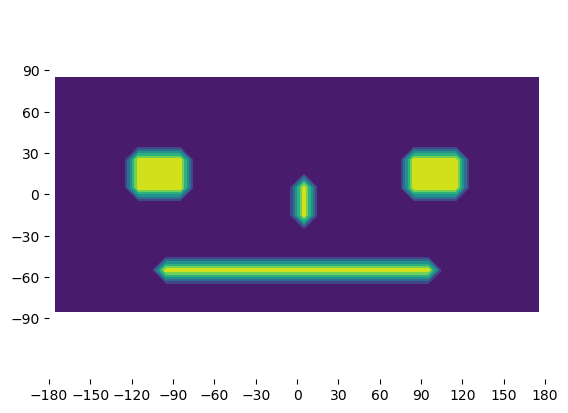

In [3]:
synthField()



# Create test fields for evaluation of community detection algorithm

## 1. Continental Test

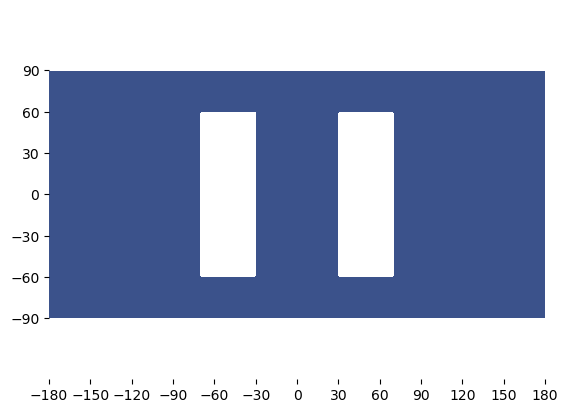

In [4]:
################################
######### Create field #########
################################
x = synthField(resolution=1, registration='pixel', outputFID='name')

x.addShape(shape='square', size=20, position=[-50, 0], magnitude=np.nan, verbose=False)
x.addShape(shape='square', size=20, position=[-50, 40], magnitude=np.nan, verbose=False)
x.addShape(shape='square', size=20, position=[-50, -40], magnitude=np.nan, verbose=False)

x.addShape(shape='square', size=20, position=[+50, 0], magnitude=np.nan, verbose=False)
x.addShape(shape='square', size=20, position=[+50, 40], magnitude=np.nan, verbose=False)
x.addShape(shape='square', size=20, position=[+50, -40], magnitude=np.nan, verbose=False)


x.plot(verbose=False);


################################
### Test community detection ###
################################



## 2. Continental Test w/ shallow ocean connection (e.g., MOR)

Variable		Dimensions			Shape
--------------------------------------------------------------------------------------
lat                     ('lat',)                        (180,)                          
lon                     ('lon',)                        (360,)                          
highlatlat              ()                              ()                              
highlatA                ()                              ()                              
VOC                     ()                              ()                              
AOC                     ()                              ()                              
bathymetry              ('lat', 'lon')                  (180, 360)                      
areaWeights             ('lat',)                        (180,)                          


/home/bogumil/Documents/External_fids/ExoCcycle-workspace/ExoCcycle/utils.py:6546: RuntimeWarning: invalid value encountered in sqrt
  c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
sh: 1: temp.txt: not found


Duplicates removed: 1306
Grid saved to: EA_Nodes_1.0_xyz.txt


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27414/27414 [00:06<00:00, 4431.32it/s]


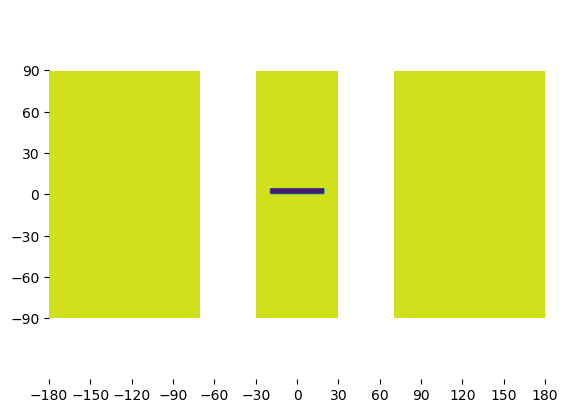

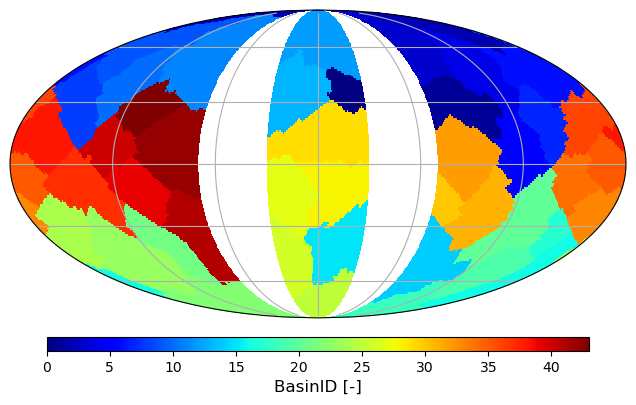

In [11]:
################################
######### Create field #########
################################
x = synthField(resolution=1, registration='pixel', outputFID='syntheticBody2a.nc')

x.addShape(shape='square', size=20, position=[-50, 0], magnitude=np.nan, verbose=False)
x.addShape(shape='square', size=20, position=[-50, 40], magnitude=np.nan, verbose=False)
x.addShape(shape='square', size=20, position=[-50, -40], magnitude=np.nan, verbose=False)
x.addShape(shape='square', size=20, position=[-50, 80], magnitude=np.nan, verbose=False)
x.addShape(shape='square', size=20, position=[-50, -80], magnitude=np.nan, verbose=False)


x.addShape(shape='square', size=20, position=[+50, 0], magnitude=np.nan, verbose=False)
x.addShape(shape='square', size=20, position=[+50, 40], magnitude=np.nan, verbose=False)
x.addShape(shape='square', size=20, position=[+50, -40], magnitude=np.nan, verbose=False)
x.addShape(shape='square', size=20, position=[+50, 80], magnitude=np.nan, verbose=False)
x.addShape(shape='square', size=20, position=[+50, -80], magnitude=np.nan, verbose=False)

# Add lines at least 3 degrees of lines
thicknessDeg = 5
for i in range(int(thicknessDeg//x.resolution)):
    x.addLine(startPos=[-20-x.resolution/2, i*x.resolution+x.resolution/2], endPos=[+20+x.resolution/2,i*x.resolution+x.resolution/2], magnitude=.5, verbose=False)

x.plot(verbose=False);

x.makenetCDF()

################################
### Test community detection ###
################################

# Create a Basins object with equal area nodes
basinEA = EC.utils.BasinsEA(dataDir=os.getcwd()+'/',
                            filename='syntheticBody2a.nc',
                            body='syntheticBody2a')

# Define basins using Louvain algorithm
basinEA.defineBasins(minBasinCnt = 3,
                     method = "Louvain",
                     reducedRes={"on":True,"factor":1},
                     read=False,
                     write=True,
                     verbose=False)


EC.utils.plotGlobal(basinEA.lat, basinEA.lon, basinEA.BasinIDA,
                    outputDir = os.getcwd(),
                    fidName = "syntheticBody2a.png",
                    cmapOpts={"cmap":"jet",
                              "cbar-title":"cbar-title",
                              "cbar-range":[0,np.nanmax(basinEA.BasinIDA)]},
                    pltOpts={"valueType": "BasinID",
                             "valueUnits": "-",
                             "plotTitle":"",
                             "plotZeroContour":False},
                    savePNG=False,
                    saveSVG=False)



Variable		Dimensions			Shape
--------------------------------------------------------------------------------------
lat                     ('lat',)                        (180,)                          
lon                     ('lon',)                        (360,)                          
highlatlat              ()                              ()                              
highlatA                ()                              ()                              
VOC                     ()                              ()                              
AOC                     ()                              ()                              
bathymetry              ('lat', 'lon')                  (180, 360)                      
areaWeights             ('lat',)                        (180,)                          


/home/bogumil/Documents/External_fids/ExoCcycle-workspace/ExoCcycle/utils.py:6546: RuntimeWarning: invalid value encountered in sqrt
  c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
sh: 1: temp.txt: not found


Duplicates removed: 1306
Grid saved to: EA_Nodes_1.0_xyz.txt


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27414/27414 [00:06<00:00, 4421.30it/s]


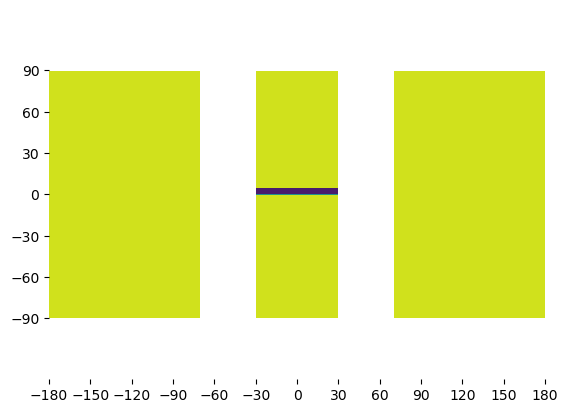

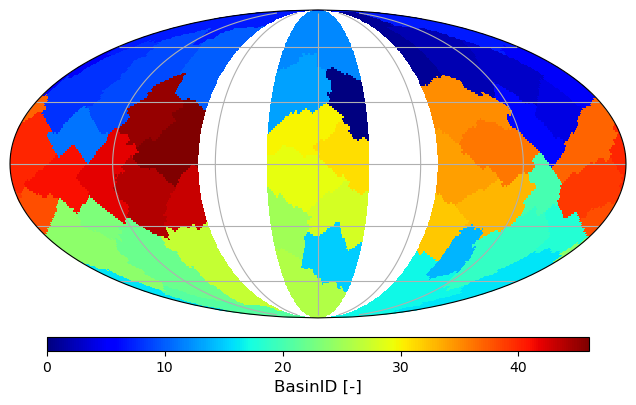

In [12]:
################################
######### Create field #########
################################
x = synthField(resolution=1, registration='pixel', outputFID='syntheticBody2b.nc')

x.addShape(shape='square', size=20, position=[-50, 0], magnitude=np.nan, verbose=False)
x.addShape(shape='square', size=20, position=[-50, 40], magnitude=np.nan, verbose=False)
x.addShape(shape='square', size=20, position=[-50, -40], magnitude=np.nan, verbose=False)
x.addShape(shape='square', size=20, position=[-50, 80], magnitude=np.nan, verbose=False)
x.addShape(shape='square', size=20, position=[-50, -80], magnitude=np.nan, verbose=False)


x.addShape(shape='square', size=20, position=[+50, 0], magnitude=np.nan, verbose=False)
x.addShape(shape='square', size=20, position=[+50, 40], magnitude=np.nan, verbose=False)
x.addShape(shape='square', size=20, position=[+50, -40], magnitude=np.nan, verbose=False)
x.addShape(shape='square', size=20, position=[+50, 80], magnitude=np.nan, verbose=False)
x.addShape(shape='square', size=20, position=[+50, -80], magnitude=np.nan, verbose=False)

# Add lines at least 3 degrees of lines
thicknessDeg = 5
for i in range(int(thicknessDeg//x.resolution)):
    x.addLine(startPos=[-30-x.resolution/2, i*x.resolution+x.resolution/2], endPos=[+30+x.resolution/2,i*x.resolution+x.resolution/2], magnitude=.5, verbose=False)

x.plot(verbose=False);

x.makenetCDF()

################################
### Test community detection ###
################################

# Create a Basins object with equal area nodes
basinEA = EC.utils.BasinsEA(dataDir=os.getcwd()+'/',
                            filename='syntheticBody2b.nc',
                            body='syntheticBody2b')

# Define basins using Louvain algorithm
basinEA.defineBasins(minBasinCnt = 3,
                     method = "Louvain",
                     reducedRes={"on":True,"factor":1},
                     read=False,
                     write=True,
                     verbose=False)


EC.utils.plotGlobal(basinEA.lat, basinEA.lon, basinEA.BasinIDA,
                    outputDir = os.getcwd(),
                    fidName = "syntheticBody2b.png",
                    cmapOpts={"cmap":"jet",
                              "cbar-title":"cbar-title",
                              "cbar-range":[0,np.nanmax(basinEA.BasinIDA)]},
                    pltOpts={"valueType": "BasinID",
                             "valueUnits": "-",
                             "plotTitle":"",
                             "plotZeroContour":False},
                    savePNG=False,
                    saveSVG=False)



## 2. Shallow ocean connection (e.g., MOR)

Variable		Dimensions			Shape
--------------------------------------------------------------------------------------
lat                     ('lat',)                        (180,)                          
lon                     ('lon',)                        (360,)                          
highlatlat              ()                              ()                              
highlatA                ()                              ()                              
VOC                     ()                              ()                              
AOC                     ()                              ()                              
bathymetry              ('lat', 'lon')                  (180, 360)                      
areaWeights             ('lat',)                        (180,)                          


sh: 1: temp.txt: not found


Duplicates removed: 1306
Grid saved to: EA_Nodes_1.0_xyz.txt


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34994/34994 [00:10<00:00, 3473.11it/s]


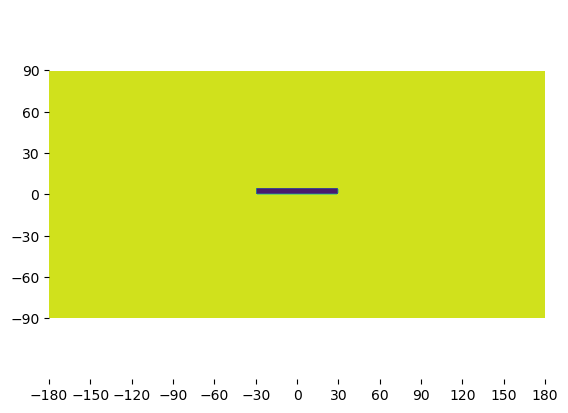

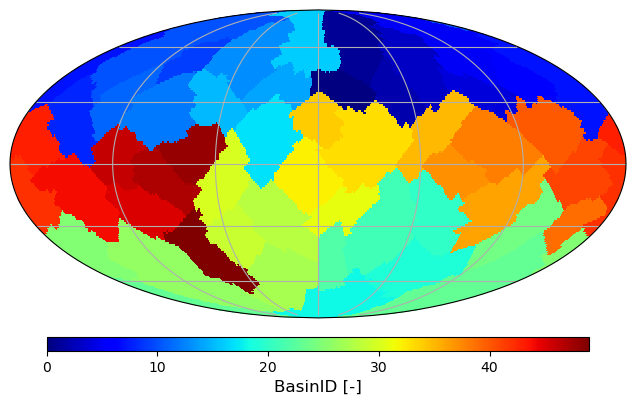

In [14]:
################################
######### Create field #########
################################
x = synthField(resolution=1, registration='pixel', outputFID='syntheticBody3a.nc')


# Add lines at least 3 degrees of lines
thicknessDeg = 5
for i in range(int(thicknessDeg//x.resolution)):
    x.addLine(startPos=[-30-x.resolution/2, i*x.resolution+x.resolution/2], endPos=[+30+x.resolution/2,i*x.resolution+x.resolution/2], magnitude=.5, verbose=False)

x.plot(verbose=False);

x.makenetCDF()

################################
### Test community detection ###
################################

# Create a Basins object with equal area nodes
basinEA = EC.utils.BasinsEA(dataDir=os.getcwd()+'/',
                            filename='syntheticBody3a.nc',
                            body='syntheticBody3a')

# Define basins using Louvain algorithm
basinEA.defineBasins(minBasinCnt = 3,
                     method = "Louvain",
                     reducedRes={"on":True,"factor":1},
                     read=False,
                     write=True,
                     verbose=False)


EC.utils.plotGlobal(basinEA.lat, basinEA.lon, basinEA.BasinIDA,
                    outputDir = os.getcwd(),
                    fidName = "syntheticBody3a.png",
                    cmapOpts={"cmap":"jet",
                              "cbar-title":"cbar-title",
                              "cbar-range":[0,np.nanmax(basinEA.BasinIDA)]},
                    pltOpts={"valueType": "BasinID",
                             "valueUnits": "-",
                             "plotTitle":"",
                             "plotZeroContour":False},
                    savePNG=False,
                    saveSVG=False)

Variable		Dimensions			Shape
--------------------------------------------------------------------------------------
lat                     ('lat',)                        (180,)                          
lon                     ('lon',)                        (360,)                          
highlatlat              ()                              ()                              
highlatA                ()                              ()                              
VOC                     ()                              ()                              
AOC                     ()                              ()                              
bathymetry              ('lat', 'lon')                  (180, 360)                      
areaWeights             ('lat',)                        (180,)                          


/home/bogumil/Documents/External_fids/ExoCcycle-workspace/ExoCcycle/utils.py:6546: RuntimeWarning: invalid value encountered in sqrt
  c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
sh: 1: temp.txt: not found


Duplicates removed: 1306
Grid saved to: EA_Nodes_1.0_xyz.txt


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34994/34994 [00:10<00:00, 3424.02it/s]


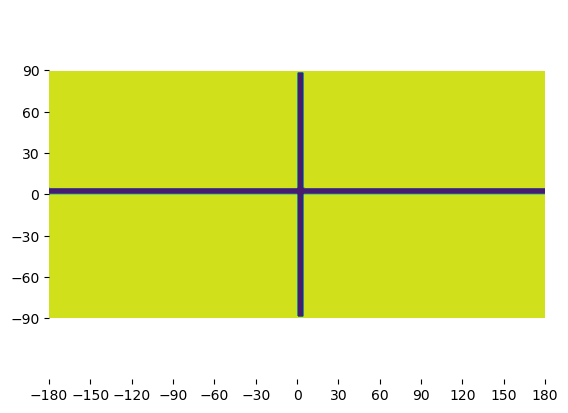

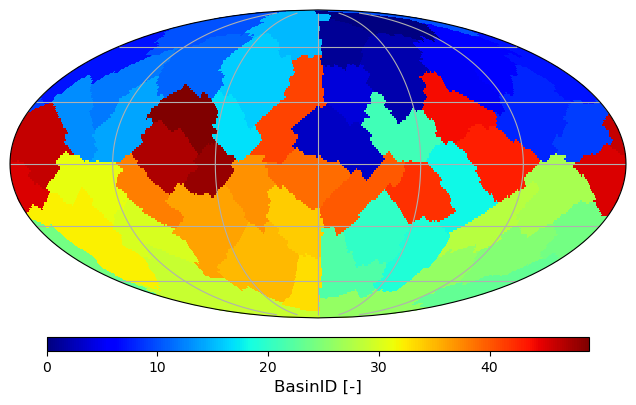

In [17]:
################################
######### Create field #########
################################
x = synthField(resolution=1, registration='pixel', outputFID='syntheticBody3b.nc')


# Add lines at least 3 degrees of lines
thicknessDeg = 5
for i in range(int(thicknessDeg//x.resolution)):
    x.addLine(startPos=[-180-x.resolution/2, i*x.resolution+x.resolution/2], endPos=[+180+x.resolution/2,i*x.resolution+x.resolution/2], magnitude=.5, verbose=False)

# Add lines at least 3 degrees of lines
thicknessDeg = 5
for i in range(int(thicknessDeg//x.resolution)):
    x.addLine(startPos=[x.resolution/2+i*x.resolution, -90+x.resolution/2], endPos=[i*x.resolution+x.resolution/2,90-x.resolution/2], magnitude=.5, verbose=False)

x.plot(verbose=False);

x.makenetCDF()

################################
### Test community detection ###
################################
# Create a Basins object with equal area nodes
basinEA = EC.utils.BasinsEA(dataDir=os.getcwd()+'/',
                            filename='syntheticBody3b.nc',
                            body='syntheticBody3b')

# Define basins using Louvain algorithm
basinEA.defineBasins(minBasinCnt = 3,
                     method = "Louvain",
                     reducedRes={"on":True,"factor":1},
                     read=False,
                     write=True,
                     verbose=False)


EC.utils.plotGlobal(basinEA.lat, basinEA.lon, basinEA.BasinIDA,
                    outputDir = os.getcwd(),
                    fidName = "syntheticBody3b.png",
                    cmapOpts={"cmap":"jet",
                              "cbar-title":"cbar-title",
                              "cbar-range":[0,np.nanmax(basinEA.BasinIDA)]},
                    pltOpts={"valueType": "BasinID",
                             "valueUnits": "-",
                             "plotTitle":"",
                             "plotZeroContour":False},
                    savePNG=False,
                    saveSVG=False)


# Compare Girvan-Newman & Louvain

/home/bogumil/anaconda3/envs/ExoCcycle/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Variable		Dimensions			Shape
--------------------------------------------------------------------------------------
lat                     ('lat',)                        (36,)                           
lon                     ('lon',)                        (72,)                           
highlatlat              ()                              ()                              
highlatA                ()                              ()                              
VOC                     ()                              ()                              
AOC                     ()                              ()                              
bathymetry              ('lat', 'lon')                  (36, 72)                        
areaWeights             ('lat',)                        (36,)                           


/home/bogumil/Documents/External_fids/ExoCcycle-workspace/ExoCcycle/utils.py:6841: RuntimeWarning: invalid value encountered in sqrt
  c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
sh: 1: temp.txt: not found


Duplicates removed: 298
Grid saved to: EA_Nodes_5.0_xyz.txt


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2592/2592 [00:00<00:00, 17590.11it/s]


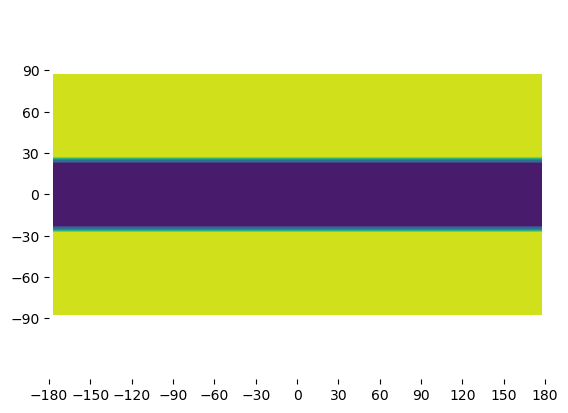

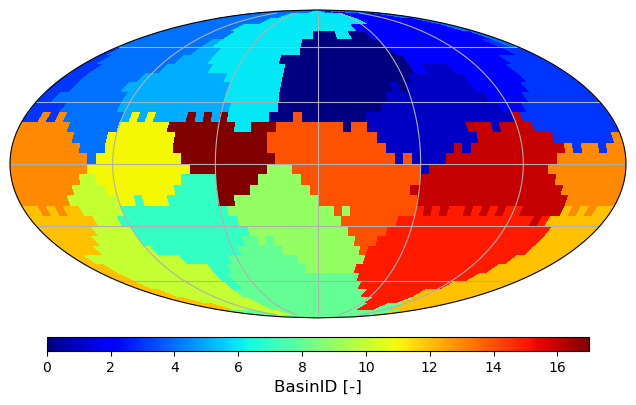

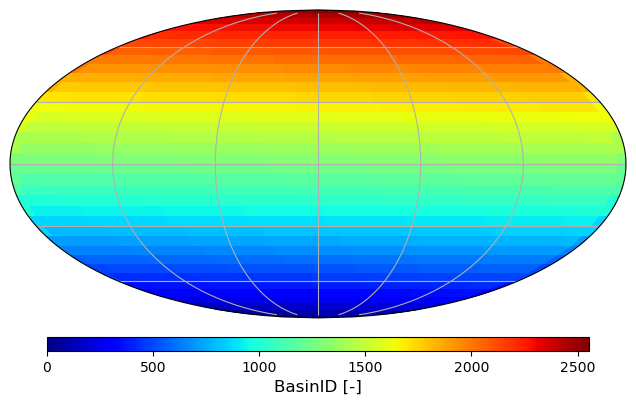

In [1]:
# Import necessary libraries
import ExoCcycle as EC
import os
import matplotlib as mpl
import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset


################################
######### Create field #########
################################
filename = "syntheticBody4a"
resolution = 5;
lineThicknessFactor = 10;

x = EC.utils.synthField(resolution=resolution, registration='pixel', outputFID=filename+'.nc')


# Add lines at least thicknessDeg degrees of lines
thicknessDeg = resolution*lineThicknessFactor
for i in range(int(thicknessDeg//x.resolution)):
    x.addLine(startPos=[-180-x.resolution/2,
                        i*x.resolution+x.resolution/2-thicknessDeg/2],
              endPos=[+180+x.resolution/2,
                      i*x.resolution+x.resolution/2-thicknessDeg/2],
              magnitude=.5, verbose=False)
    
'''
shift = resolution*(44//resolution);
for i in range(int(thicknessDeg//x.resolution)):
    x.addLine(startPos=[-180-x.resolution/2,
                        shift+i*x.resolution+x.resolution/2-thicknessDeg/2],
              endPos=[+180+x.resolution/2,
                      shift+i*x.resolution+x.resolution/2-thicknessDeg/2],
              magnitude=.5, verbose=False)

shift = -resolution*(45//resolution);
for i in range(int(thicknessDeg//x.resolution)):
    x.addLine(startPos=[-180-x.resolution/2,
                        shift+i*x.resolution+x.resolution/2-thicknessDeg/2],
              endPos=[+180+x.resolution/2,
                      shift+i*x.resolution+x.resolution/2-thicknessDeg/2],
              magnitude=.5, verbose=False)
'''
    
'''
# Add lines at least thicknessDeg degrees of lines
for i in range(int(thicknessDeg//x.resolution)):
    x.addLine(startPos=[x.resolution/2+i*x.resolution-thicknessDeg/2,
                        -90], 
              endPos=[i*x.resolution+x.resolution/2-thicknessDeg/2,
                      90], magnitude=.5, verbose=False)

'''

x.plot(verbose=False);


x.makenetCDF()

################################
### Test community detection ###
################################
# Create a Basins object with equal area nodes
basinEA = EC.utils.BasinsEA(dataDir=os.getcwd()+'/',
                            filename=filename+'.nc',
                            body=filename)

# Define basins using Louvain algorithm
basinEA.defineBasins(minBasinCnt = 3,
                     method = "Louvain",
                     reducedRes={"on":True,"factor":1},
                     read=False,
                     write=True,
                     verbose=False)


EC.utils.plotGlobal(basinEA.lat, basinEA.lon, basinEA.BasinIDA,
                    outputDir = os.getcwd(),
                    fidName = filename+'.png',
                    cmapOpts={"cmap":"jet",
                              "cbar-title":"cbar-title",
                              "cbar-range":[0,np.nanmax(basinEA.BasinIDA)]},
                    pltOpts={"valueType": "BasinID",
                             "valueUnits": "-",
                             "plotTitle":"",
                             "plotZeroContour":False},
                    savePNG=False,
                    saveSVG=False)

# Create a Basins object with equal area nodes
basin = EC.utils.Basins(dataDir=os.getcwd()+'/',
                            filename=filename+'.nc',
                            body=filename)

# Define basins using Louvain algorithm
basin.defineBasins(minBasinCnt = 3,
                     method = "Louvain",
                     reducedRes={"on":True,"factor":1},
                     read=False,
                     write=True,
                     verbose=False)

basin.calculateBasinIDA()

EC.utils.plotGlobal(basin.lat, basin.lon, basin.BasinIDA,
                    outputDir = os.getcwd(),
                    fidName = filename+'.png',
                    cmapOpts={"cmap":"jet",
                              "cbar-title":"cbar-title",
                              "cbar-range":[0,np.nanmax(basin.BasinIDA)]},
                    pltOpts={"valueType": "BasinID",
                             "valueUnits": "-",
                             "plotTitle":"",
                             "plotZeroContour":False},
                    savePNG=False,
                    saveSVG=False)


/home/bogumil/anaconda3/envs/ExoCcycle/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Variable		Dimensions			Shape
--------------------------------------------------------------------------------------
lat                     ('lat',)                        (36,)                           
lon                     ('lon',)                        (72,)                           
highlatlat              ()                              ()                              
highlatA                ()                              ()                              
VOC                     ()                              ()                              
AOC                     ()                              ()                              
bathymetry              ('lat', 'lon')                  (36, 72)                        
areaWeights             ('lat',)                        (36,)                           


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2592/2592 [00:00<00:00, 18085.42it/s]

-87.5 -177.5 -87.5 177.5
-87.5 177.5 -87.5 -177.5
-82.5 -177.5 -82.5 177.5
-82.5 177.5 -82.5 -177.5
-77.5 -177.5 -77.5 177.5
-77.5 177.5 -77.5 -177.5
-72.5 -177.5 -72.5 177.5
-72.5 177.5 -72.5 -177.5
-67.5 -177.5 -67.5 177.5
-67.5 177.5 -67.5 -177.5
-62.5 -177.5 -62.5 177.5
-62.5 177.5 -62.5 -177.5
-57.5 -177.5 -57.5 177.5
-57.5 177.5 -57.5 -177.5
-52.5 -177.5 -52.5 177.5
-52.5 177.5 -52.5 -177.5
-47.5 -177.5 -47.5 177.5
-47.5 177.5 -47.5 -177.5
-42.5 -177.5 -42.5 177.5
-42.5 177.5 -42.5 -177.5
-37.5 -177.5 -37.5 177.5
-37.5 177.5 -37.5 -177.5
-32.5 -177.5 -32.5 177.5
-32.5 177.5 -32.5 -177.5
-27.5 -177.5 -27.5 177.5
-27.5 177.5 -27.5 -177.5
-22.5 -177.5 -22.5 177.5
-22.5 177.5 -22.5 -177.5
-17.5 -177.5 -17.5 177.5
-17.5 177.5 -17.5 -177.5
-12.5 -177.5 -12.5 177.5
-12.5 177.5 -12.5 -177.5
-7.5 -177.5 -7.5 177.5
-7.5 177.5 -7.5 -177.5
-2.5 -177.5 -2.5 177.5
-2.5 177.5 -2.5 -177.5
2.5 -177.5 2.5 177.5
2.5 177.5 2.5 -177.5
7.5 -177.5 7.5 177.5
7.5 177.5 7.5 -177.5
12.5 -177.5 12.5 177.5
1

(36, 72)

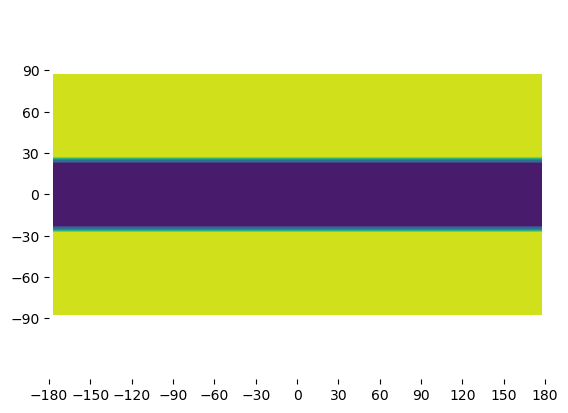

In [1]:
# Import necessary libraries
import ExoCcycle as EC
import os
import matplotlib as mpl
import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset



################################
######### Create field #########
################################
filename = "syntheticBody4a"
resolution = 5;
lineThicknessFactor = 10;

x = EC.utils.synthField(resolution=resolution, registration='pixel', outputFID=filename+'.nc')

# Add lines at least thicknessDeg degrees of lines
thicknessDeg = resolution*lineThicknessFactor
for i in range(int(thicknessDeg//x.resolution)):
    x.addLine(startPos=[-180-x.resolution/2,
                        i*x.resolution+x.resolution/2-thicknessDeg/2],
              endPos=[+180+x.resolution/2,
                      i*x.resolution+x.resolution/2-thicknessDeg/2],
              magnitude=.5, verbose=False)

x.plot(verbose=False);

x.makenetCDF()




# Create a Basins object with equal area nodes
basin = EC.utils.Basins(dataDir=os.getcwd()+'/',
                            filename=filename+'.nc',
                            body=filename)

# Define basins using Louvain algorithm
basin.defineBasinsNonUnique(minBasinCnt = 3,
                     method = "Louvain",
                     reducedRes={"on":True,"factor":1},
                     edgeParaOpt={"Parameter":"Bathymetry", "readParm":None},
                     read=False,
                     write=True,
                     verbose=False)



# Define arrays for latitude, longitude, bathymetry (use the reduced resolution)
latA = basin.lat[::basin.reducedRes].T[::basin.reducedRes].T
lonA = basin.lon[::basin.reducedRes].T[::basin.reducedRes].T

# Define array for basinIDs and corresponding node ids (use the reduced resolution)
nodePosDict = basin.G.nodes.data('pos');
nodeBasinID = basin.G.nodes.data('basinID');
pos = np.zeros( (len(nodePosDict), 2) );
BasinID = np.zeros( (len(nodeBasinID), 1) );
for i in range(len(nodePosDict)):
    pos[i,:] = nodePosDict[i];
    BasinID[i] = nodeBasinID[i]['basinID'];

BasinIDA = np.empty(np.shape(lonA));
BasinIDA[:] = np.nan;
for nodei in range(len(pos[:,1])):
    BasinIDA[(lonA==pos[nodei,1])&(latA==pos[nodei,0])] = BasinID[nodei];


BasinIDA.shape


In [1]:
################################
######### Create field #########
################################
filename = "syntheticBody4a"
resolution = 10
x = synthField(resolution=resolution, registration='pixel', outputFID=filename+'.nc')

# Add lines at least thicknessDeg degrees of lines
thicknessDeg = resolution*2
for i in range(int(thicknessDeg//x.resolution)):
    x.addLine(startPos=[-180-x.resolution/2,
                        i*x.resolution+x.resolution/2-thicknessDeg/2],
              endPos=[+180+x.resolution/2,
                      i*x.resolution+x.resolution/2-thicknessDeg/2],
              magnitude=.5, verbose=False)

# Add lines at least thicknessDeg degrees of lines
for i in range(int(thicknessDeg//x.resolution)):
    x.addLine(startPos=[x.resolution/2+i*x.resolution-thicknessDeg/2,
                        -90], 
              endPos=[i*x.resolution+x.resolution/2-thicknessDeg/2,
                      90], magnitude=.5, verbose=False)

x.plot(verbose=False);

x.makenetCDF()

################################
### Test community detection ###
################################
# Create a Basins object with equal area nodes
basinEA = EC.utils.BasinsEA(dataDir=os.getcwd()+'/',
                            filename=filename+'.nc',
                            body=filename)

# Define basins using Louvain algorithm
basinEA.defineBasins(minBasinCnt = 11,
                     method = "Girvan-Newman",
                     reducedRes={"on":True,"factor":1},
                     read=False,
                     write=True,
                     verbose=False)


EC.utils.plotGlobal(basinEA.lat, basinEA.lon, basinEA.BasinIDA,
                    outputDir = os.getcwd(),
                    fidName = filename+'.png',
                    cmapOpts={"cmap":"jet",
                              "cbar-title":"cbar-title",
                              "cbar-range":[0,np.nanmax(basinEA.BasinIDA)]},
                    pltOpts={"valueType": "BasinID",
                             "valueUnits": "-",
                             "plotTitle":"",
                             "plotZeroContour":False},
                    savePNG=False,
                    saveSVG=False)


NameError: name 'synthField' is not defined